# Multifractal Detrended Moving Average (MF-DMA) Module

Reference:

Gu, Gao-Feng Gu, and Wei-Xing Zhou. "Detrending moving average algorithm for multifractals." Physical Review E, no. 82, 2010, pp. 011136,

Arianos, Sergio, and Anna Carbone. "De trending moving average algorithm: A closed-form approximation of the scaling law." Physica A, no.382, 2007, pp. 9–15

In [1]:
import array
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
files = 'https://raw.githubusercontent.com/y3kiys4/wqu_capstone_june2023_grp3626/main/SPX_1m_Dec2020_Jun2023.csv'

df = pd.read_csv(files)
# Set timestamp as index
df = df.set_index(df['Time'])
df.drop(['Time'], axis=1, inplace=True)
df.index = pd.to_datetime(df.index)

# Calculate log return
df['log_ret'] = 10000 * np.log(df.Price).diff() # 10,000 times log return

# Calculate the time difference in mininutes
df['deltaT'] = (df.index.to_series().diff().dt.days.mul(60*24, fill_value=0) +
                df.index.to_series().diff().dt.seconds.div(60, fill_value=0)
               )

df_1min = df[df['deltaT'] == 1]
df_1min['log_ret_sq'] = np.square(df_1min['log_ret'])
df_1min

C:\Users\cutef\AppData\Local\Temp\ipykernel_6084\374198705.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1min['log_ret_sq'] = np.square(df_1min['log_ret'])


,Price,log_ret,deltaT,log_ret_sq
Time,,,,
2020-12-01 00:01:00,3654.045,1.932292,1.0,3.733753
2020-12-01 00:02:00,3654.336,0.796346,1.0,0.634167
2020-12-01 00:03:00,3653.945,-1.070019,1.0,1.144941
2020-12-01 00:04:00,3653.845,-0.273681,1.0,0.074901
2020-12-01 00:05:00,3653.299,-1.494428,1.0,2.233315
...,...,...,...,...
2023-06-30 16:09:00,4446.311,-1.171689,1.0,1.372856
2023-06-30 16:10:00,4445.570,-1.666689,1.0,2.777852
2023-06-30 16:11:00,4445.332,-0.535379,1.0,0.286630


## 1. Construct the sequence of cumulative sums

<AxesSubplot:xlabel='Time'>

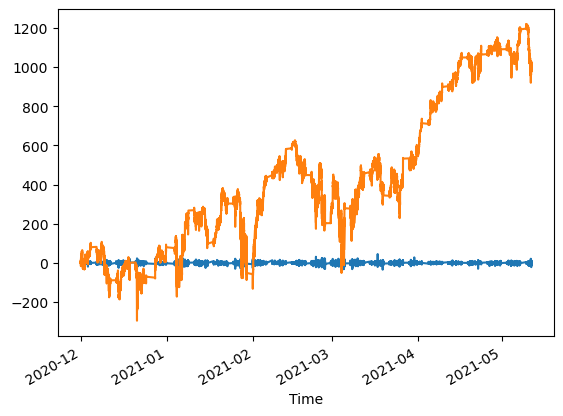

In [3]:
n_sample = 60 * 24 * 100

cs = pd.DataFrame(df_1min['log_ret'][:n_sample], columns = ['log_ret'])
cs['cum_sum'] = cs['log_ret']
cs['cum_sum'] = cs['cum_sum'].cumsum()

cs['log_ret'].plot()
cs['cum_sum'].plot()

In [4]:
cs

,log_ret,cum_sum
Time,,
2020-12-01 00:01:00,1.932292,1.932292
2020-12-01 00:02:00,0.796346,2.728638
2020-12-01 00:03:00,-1.070019,1.658619
2020-12-01 00:04:00,-0.273681,1.384938
2020-12-01 00:05:00,-1.494428,-0.109489
...,...,...
2021-05-11 15:56:00,10.282824,1007.360238
2021-05-11 15:57:00,0.599867,1007.960105
2021-05-11 15:58:00,1.657275,1009.617380


In [5]:
lags = np.unique(np.logspace(0.5, 4, 100).astype(int))
len_total = len(cs['cum_sum'])
q = 2

In [6]:
starttime_total = time.time()

F = []
len_total = len(cs['cum_sum'])

for lag in lags:
    starttime_epoch = time.time()
    mean_temp = []

    # Calculate moving average
    for i in range(len(cs['cum_sum'])-lag+1):
        mean_temp.append(np.mean(cs['cum_sum'][i:i+lag]))
    
    # Detrend
    diff_temp = np.subtract(np.array(mean_temp), cs['cum_sum'][lag-1:].values)
    
    # Slice into non-overlapping segments
    segs_temp = pd.DataFrame(np.resize(diff_temp, (lag, len(diff_temp) // lag)))

    # Calculate fluctuation variance
    F_seg_sq_temp = np.array((segs_temp ** 2).mean(axis=0)) 
    
    # Calculate the qth order fluctuation function
    F_temp = ((1 / lag) * (F_seg_sq_temp ** (q / 2)).sum()) ** (1 / q)
    
    F.append(F_temp)    
    
    endtime_epoch = time.time()
    print(f'Lag is {lag}, q is {q}, F_temp is {F_temp}, Epoch time spent is {endtime_epoch-starttime_epoch}', '\n')
    
endtime_total = time.time()
total_time = endtime_total - starttime_total

print(f'F is {F}', '\n', f'Total time spent is: \
      {int(total_time // 60)} min {int(total_time % 60)} sec') 

Lag is 3, q is 2, F_temp is 241.092485165519, Epoch time spent is 18.820427656173706 

Lag is 4, q is 2, F_temp is 227.10244438168246, Epoch time spent is 18.7414972782135 

Lag is 5, q is 2, F_temp is 212.7187261555844, Epoch time spent is 19.10590147972107 

Lag is 6, q is 2, F_temp is 199.83230127250297, Epoch time spent is 18.813514471054077 

Lag is 7, q is 2, F_temp is 188.64209005726022, Epoch time spent is 18.968300342559814 

Lag is 8, q is 2, F_temp is 178.88922703512267, Epoch time spent is 18.892789363861084 

Lag is 9, q is 2, F_temp is 170.3853510220118, Epoch time spent is 18.902951955795288 

Lag is 10, q is 2, F_temp is 162.97915106811644, Epoch time spent is 18.989639043807983 

Lag is 11, q is 2, F_temp is 156.43336064161366, Epoch time spent is 18.811814069747925 

Lag is 12, q is 2, F_temp is 150.60326237841278, Epoch time spent is 19.31665825843811 

Lag is 13, q is 2, F_temp is 145.3866533997718, Epoch time spent is 18.82757019996643 

Lag is 14, q is 2, F_temp i

In [12]:
log10_lag = np.log10(lags)
log10_F = np.log10(F) ** (-1)
fit = np.polyfit(log10_lag, log10_F, 1)
hurst = fit[1]
print(f'The Hurst exponent is {hurst}')

The Hurst exponent is 0.07045509006235033


In [13]:
fit

array([0.28428213, 0.07045509])

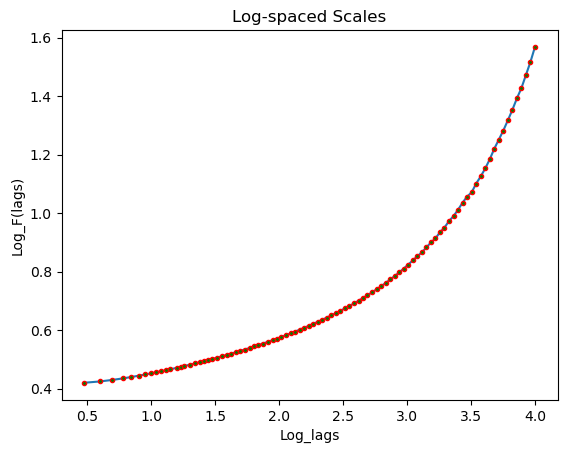

In [14]:
x_hurst = np.linspace(np.log10(lags.min()), np.log10(lags.max())+0.1, num=len(lags))
y_hurst = fit[0] + hurst * x_hurst

plt.plot(log10_lag, log10_F, marker="o", markersize=3, markeredgecolor="red", markerfacecolor="green")
# plt.plot(x_hurst, y_hurst)
plt.xlabel('Log_lags')
plt.ylabel('Log_F(lags)')
plt.title('Log-spaced Scales')
plt.show()

In [10]:
# starttime = time.time()

# lags = np.unique(np.logspace(0.5, 3, 10).astype(int))
# len_total = len(cs['cum_sum'])

# sigma_dma_sq = []
# for lag in lags:
#     mean_temp = []

#     for i in range(len(cs['cum_sum']), lag-1, -1):
#         mean_temp.append(np.mean(cs['cum_sum'][len_total-lag:len_total]))
    
#     diff_temp = np.subtract(np.array(mean_temp), cs['cum_sum'][lag-1:].values)
#     var_temp = np.float_power(diff_temp, 2)
#     sigma_dma_sq_temp = (1 / lag) * var_temp.sum()
#     sigma_dma_sq.append(sigma_dma_sq_temp)
    
#     print(f'lag is {lag}, var_temp_sum is {var_temp.sum()}, sigma_dma_sq_temp is {sigma_dma_sq_temp}', '\n')

# endtime = time.time()
# print(f'sigma_dma_sq is {sigma_dma_sq}', '\n', f'Time spent is: {endtime-starttime}')